**Tasks**

**Simple decision trees**

Can you do better than the k-NN baseline with decision trees?

- What accuracy can you achieve with a depth of 3?
- Plot the corresponding tree with graphviz
- Do you get better results if you reduce the number of dimensions with PCA first?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz


import graphviz

%matplotlib inline

In [2]:
# get the class label limit
class_limit = 6

# class names
class_names = ["car", "bike", "other", "van", "motorcycle", "truck"]

In [3]:
# Load the numpy .npy file
train_dataset_array = np.load("train_dataset_array.npy")
train_dataset_array_labels = np.load("train_dataset_array_labels.npy")
train_dataset_array_features = np.load("train_features.npy")

print('Train data loaded')

Train data loaded


In [4]:
# Load the numpy .npy file
test_dataset_array = np.load("test_dataset_array.npy")
test_dataset_array_labels = np.load("test_dataset_array_labels.npy")
test_dataset_array_features = np.load("test_features.npy")

print('Test data loaded')

Test data loaded


In [5]:
# Load the numpy .npy file
valid_dataset_array = np.load("valid_dataset_array.npy")
valid_dataset_array_labels = np.load("valid_dataset_array_labels.npy")
valid_dataset_array_features = np.load("valid_features.npy")

print('Validation data loaded')

Validation data loaded


In [6]:
# Create X/y arrays
X_tr = train_dataset_array_features
y_tr = train_dataset_array_labels

print('X:', X_tr.shape, X_tr.dtype)
print('y:', y_tr.shape, y_tr.dtype)

X: (280, 1024) float32
y: (280,) int64


In [7]:
# Create X/y arrays
X_val = valid_dataset_array_features
y_val = valid_dataset_array_labels

print('X_val:', X_val.shape, X_val.dtype)
print('y_val:', y_val.shape, y_val.dtype)

X_val: (139, 1024) float32
y_val: (139,) int64


In [8]:
# Create X/y arrays
X_te = test_dataset_array_features
y_te = test_dataset_array_labels

print('X_te:', X_te.shape, X_te.dtype)
print('y_te:', y_te.shape, y_te.dtype)

X_te: (50, 1024) float32
y_te: (50,) int64


In [9]:
def label_img(number):
    # conversion 
    if number==0 : return 'car'
    #                             
    if number==1 : return 'bike'
    #                             
    if number==2 : return 'other'
    #                             
    if number==3 : return 'van'
    #                             
    if number==4 : return 'motorcycle'
    #                             
    if number==5 : return 'truck'

In [10]:
# Create decision tree
dt = DecisionTreeClassifier(
    criterion='gini', max_depth=3, random_state=0)

In [11]:
# Fit decision tree
dt.fit(X_tr, y_tr)

# Get score
dt.score(X_tr, y_tr)

0.7928571428571428

In [12]:
pd.value_counts(y_tr, normalize=True)

1    0.235714
0    0.228571
4    0.182143
5    0.150000
2    0.114286
3    0.089286
dtype: float64

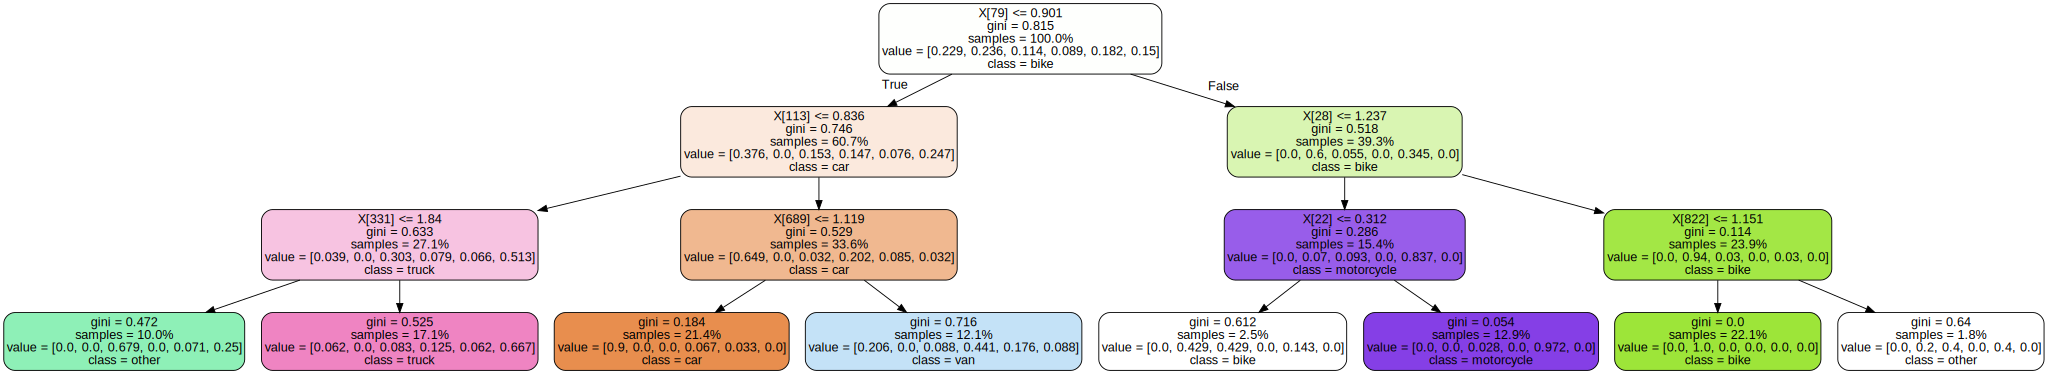

In [13]:
# Export decision tree
dot_data = export_graphviz(
    dt, out_file=None,
    class_names=class_names,
    filled=True, rounded=True, proportion=True   
)

# Display it
graphviz.Source(dot_data)

In [14]:
# We use pca as preproccessing and set it to 150 in order to retain 90+% of the variance and prevent overfitting
pipe = Pipeline([('pca', PCA(n_components=150)),
                 ('tree', DecisionTreeClassifier())])

In [15]:
# We try different levels of depth around 3
n_depths = np.arange(1, 6)

grid = ParameterGrid({'tree__max_depth': n_depths,
                     })

print ('Possible combinations:', len(grid))

Possible combinations: 5


In [16]:
tree_score = []

# Grid search
for params_dict in grid:
    pipe.set_params(**params_dict)
    pipe.fit(X_tr, y_tr)
    params_dict['train accuracy'] = pipe.score(X_tr, y_tr)
    tree_score.append(params_dict)
    params_dict['validation accuracy'] = pipe.score(X_val, y_val)
    tree_score.append(params_dict)
    params_dict['test accuracy'] = pipe.score(X_te, y_te)
    tree_score.append(params_dict)

In [17]:
tree_df = pd.DataFrame(tree_score)
tree_df.sort_values(by='test accuracy', ascending=False).head()

,tree__max_depth,train accuracy,validation accuracy,test accuracy
12,5,0.932143,0.820144,0.84
13,5,0.932143,0.820144,0.84
14,5,0.932143,0.820144,0.84
6,3,0.800000,0.762590,0.82
7,3,0.800000,0.762590,0.82


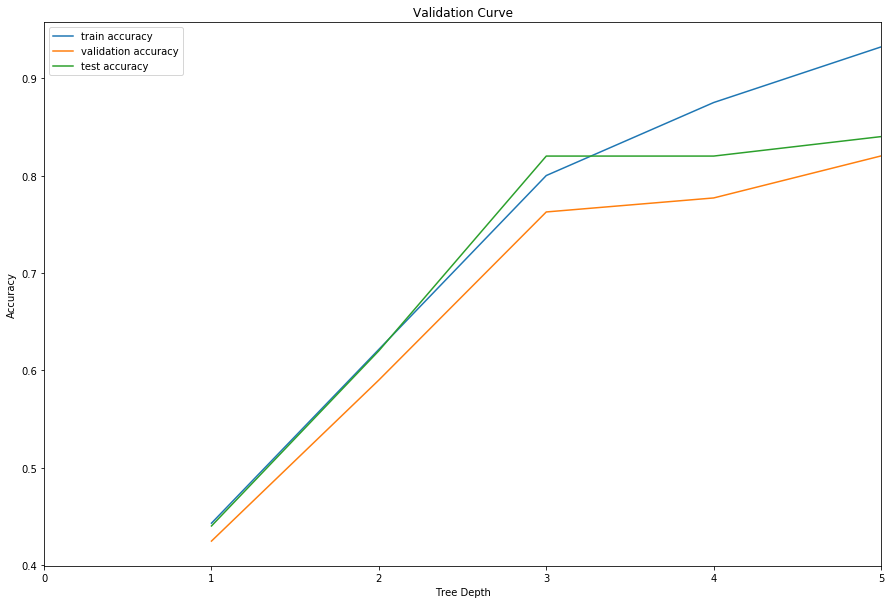

In [18]:
tree_df.plot(x='tree__max_depth', figsize=(15, 10) )
plt.title('Validation Curve')
plt.xlabel('Tree Depth')
plt.xticks(range(6))
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
best_tr = tree_df['train accuracy'].idxmax()
print ('Best accuracy on the train set: {} with a depth of {}'
       .format(tree_df.loc[best_tr,'train accuracy'], tree_df.loc[best_tr,'tree__max_depth']))

Best accuracy on the train set: 0.9321428571428572 with a depth of 5


In [20]:
best_te = tree_df['test accuracy'].idxmax()
print ('Best accuracy on the test set: {} with a depth of {}'
       .format(tree_df.loc[best_te,'test accuracy'], tree_df.loc[best_te,'tree__max_depth']))

Best accuracy on the test set: 0.84 with a depth of 5


In [21]:
best_val = tree_df['validation accuracy'].idxmax()
print ('Best accuracy on the validation set: {} with a depth of {}'
       .format(tree_df.loc[best_te,'validation accuracy'], tree_df.loc[best_val,'tree__max_depth']))

Best accuracy on the validation set: 0.8201438848920863 with a depth of 5


In [22]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'pca', 'tree', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'tree__class_weight', 'tree__criterion', 'tree__max_depth', 'tree__max_features', 'tree__max_leaf_nodes', 'tree__min_impurity_decrease', 'tree__min_impurity_split', 'tree__min_samples_leaf', 'tree__min_samples_split', 'tree__min_weight_fraction_leaf', 'tree__presort', 'tree__random_state', 'tree__splitter'])

In [23]:
pipe.set_params(tree__max_depth=5)
pipe.fit(X_tr, y_tr)

train_score = pipe.score(X_tr, y_tr)
print ("Score on the training data: ", train_score)

validation_score = pipe.score(X_val, y_val)
print ("Score on the validation data: ", validation_score)

test_score = pipe.score(X_te, y_te)
print ("Score on the test data: ", test_score)

Score on the training data:  0.9321428571428572
Score on the validation data:  0.8129496402877698
Score on the test data:  0.84
